In [2]:
import pandas as pd
import numpy as np
from datasets import load_from_disk
from setfit import sample_dataset


In [10]:
from huggingface_hub import notebook_login

notebook_login()


In [3]:
aug_stream_data = load_from_disk("data/processed/aug_stream_data")


In [13]:
train_dataset = sample_dataset(aug_stream_data["train"])
eval_dataset = aug_stream_data["validation"]
print(train_dataset)
print(eval_dataset)


Dataset({
    features: ['text', 'label'],
    num_rows: 160
})
Dataset({
    features: ['text', 'label'],
    num_rows: 1382
})


In [9]:
from setfit import SetFitModel

model_id = "sentence-transformers/all-mpnet-base-v2"
model = SetFitModel.from_pretrained(model_id)


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitTrainer

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    num_iterations=20,
    metric="f1",
    metric_kwargs={"average": "macro"}
)


/tmp/ipykernel_58195/2803454763.py:5: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/160 [00:00<?, ? examples/s]

In [23]:
trainer.train()


***** Running training *****
  Num unique pairs = 6400
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.011100
50,0.011400
100,0.006900
150,0.006900
200,0.005200
250,0.002900
300,0.002600
350,0.001300
400,0.001300


In [24]:
trainer.evaluate()


***** Running evaluation *****


{'f1': 0.5294216467829347}

In [25]:
trainer.push_to_hub("gpham/all-mpnet-base-v2-setfit-arxiv")


model_head.pkl:   0%|          | 0.00/124k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/gpham/all-mpnet-base-v2-setfit-arxiv/commit/e67a22e20a567d0e67190af30eb3a38a1386772f', commit_message='Add SetFit model', commit_description='', oid='e67a22e20a567d0e67190af30eb3a38a1386772f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/gpham/all-mpnet-base-v2-setfit-arxiv', endpoint='https://huggingface.co', repo_type='model', repo_id='gpham/all-mpnet-base-v2-setfit-arxiv'), pr_revision=None, pr_num=None)

In [26]:
model = SetFitModel.from_pretrained("gpham/all-mpnet-base-v2-setfit-arxiv")


config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/111k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config_setfit.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

model_head.pkl:   0%|          | 0.00/124k [00:00<?, ?B/s]

In [28]:
aug_stream_data.set_format(type="pandas")
train_df = aug_stream_data["train"][:]
valid_df = aug_stream_data["validation"][:]

X_train, y_train = train_df["text"], train_df["label"]
X_valid, y_valid = valid_df["text"], valid_df["label"]
labels = aug_stream_data["train"].features["label"].names

X_train_embed = model.encode(X_train, show_progress_bar=True)


Batches:   0%|          | 0/346 [00:00<?, ?it/s]

In [29]:
X_valid_embed = model.encode(X_valid, show_progress_bar=True)


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

In [30]:
X_train_embed.shape, X_valid_embed.shape


((11054, 768), (1382, 768))

In [31]:
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.utils.extmath import density
from time import time

def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
   
    t0 = time()
    clf.fit(X_train_embed, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_valid_embed)
    test_time = time() - t0
    print(f"inference time:  {test_time:.3}s")

    balanced_accuracy = balanced_accuracy_score(y_valid, pred)
    print(f"Balanced accuracy score:    {balanced_accuracy:.3}")

    macro_f1 = f1_score(y_valid, pred, average="macro")
    print(f"Macro F1 score:    {macro_f1:.3}")

    weighted_f1 = f1_score(y_valid, pred, average="weighted")
    print(f"Weighted F1 score:    {weighted_f1:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()
    
    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, balanced_accuracy, macro_f1, weighted_f1, train_time, test_time


In [32]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

results = []
for clf, name in (
    (LogisticRegression(class_weight="balanced"), "Logistic Regression"),
    (RidgeClassifier(class_weight="balanced"), "Ridge Classifier"),
    (KNeighborsClassifier(), "kNN"),
    (RandomForestClassifier(class_weight="balanced"), "RandomForest Classifier"),
    (LinearSVC(class_weight="balanced"), "Linear SVC"),
    (SGDClassifier(class_weight="balanced"), "SGD Classifier"),
    (NearestCentroid(), "NearestCentroid"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))
    

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(class_weight='balanced')
train time: 42.4s
inference time:  0.0338s
Balanced accuracy score:    0.679
Macro F1 score:    0.62
Weighted F1 score:    0.718
dimensionality: 768
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(class_weight='balanced')
train time: 0.195s
inference time:  0.0307s
Balanced accuracy score:    0.691
Macro F1 score:    0.631
Weighted F1 score:    0.721
dimensionality: 768
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier()
train time: 0.00445s
inference time:  0.374s
Balanced accuracy score:    0.635
Macro F1 score:    0.643
Weighted F1 score:    0.753

RandomForest Classifier
________________________________________________________________________________
Trainin

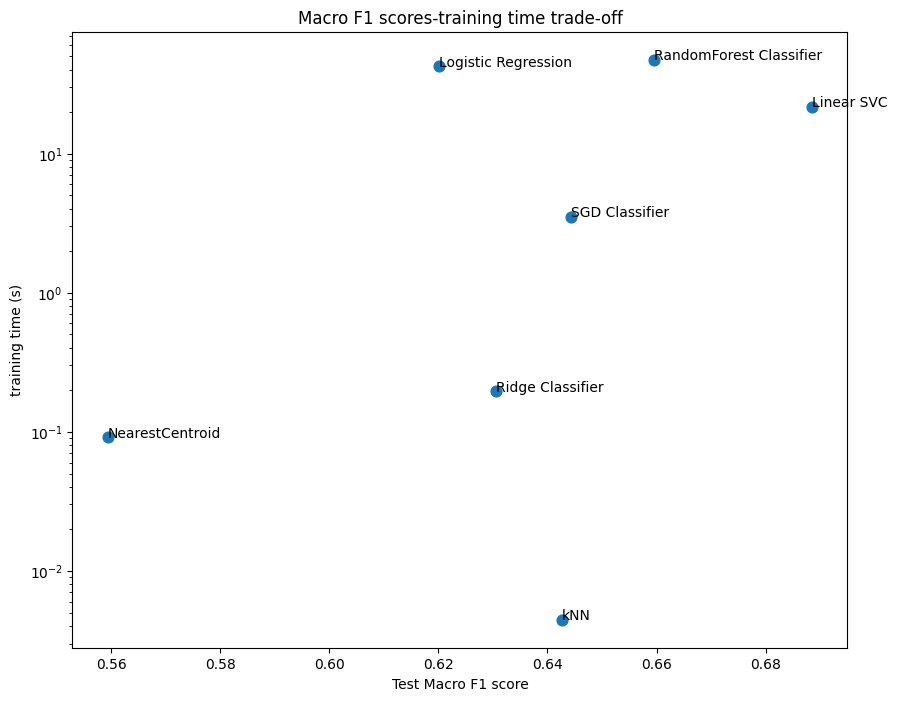

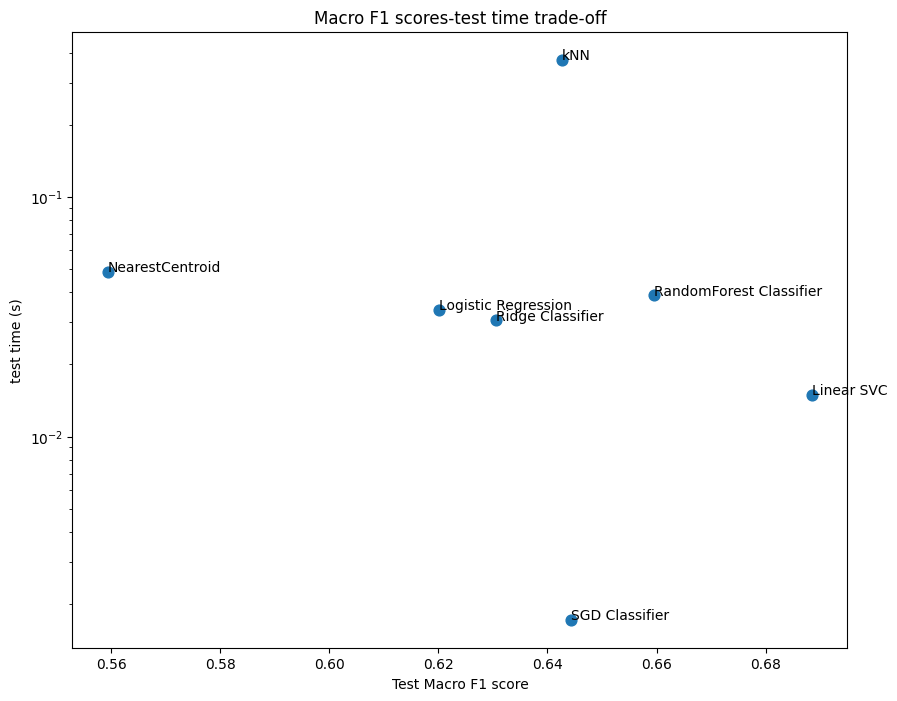

In [33]:
import numpy as np
import matplotlib.pyplot as plt  # Make sure matplotlib is imported

indices = np.arange(len(results))

# Extract all 5 elements from the results
results = [[x[i] for x in results] for i in range(6)]

# Unpack all 5 elements
clf_names, balanced_accuracy_scores, macro_f1_scores, weighted_f1_scores, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(macro_f1_scores, training_time, s=60)
ax1.set(
    title="Macro F1 scores-training time trade-off",
    yscale="log",
    xlabel="Test Macro F1 score",
    ylabel="training time (s)",
)

fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(macro_f1_scores, test_time, s=60)
ax2.set(
    title="Macro F1 scores-test time trade-off",
    yscale="log",
    xlabel="Test Macro F1 score",
    ylabel="test time (s)",
)


# Add text annotations to all plots
for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (macro_f1_scores[i], training_time[i]))
    ax2.annotate(txt, (macro_f1_scores[i], test_time[i]))
